# Er det en kat eller ej

Det første led i vores projekt, var at finde ud af om et givent billede vi har, overhovedet er en kat eller ej. Dette er et scenarie hvor der er 2 muligheder, enten er det eller også er det ikke - dette kaldes for et ```binary classification``` problem.

Det er noget der ender med at have betydning for os senere hen, når vi skal vælge hvilken loss function der skal gøres brug af.

Hvad der så vil blive beskrevet i denne notebook, hvordan vi fik oprettet et ```Convolutional Neural Network``` der er blevet trænet til at løse ```binary classification``` problemer.

## Opsætning af Notebook

På itslearning har vi fået udleveret et dokument der beskriver hvad vi skal aflevere, og hvilken opsætning dette skal have. Dette betyder selvfølgeligt at denne notebook vil overholde den angivne struktur, hvilket er:

1. Collect data.
2. Data preparation.
3. Choose model.
4. Train model.
5. Evaluation.
6. Tuning.
7. Prediction.

Indsamling af data sker ved at vi i teamet har lavet et Python script der gør brug af en API til hjemmesiden ```reddit``` som har nogle undersider hvor der er uploadet mange billeder af katte (og andre ting). Dette Python script forsøger så at hente 500 af de højeste vurderede billeder på en masse forskellige undersider til hjemmesiden. Dette er noget der skal ske både for katte, men også for elementer der netop ikke er katte.

Dataforberedelse er noget vi vil gøre brug af i form af at vi ønsker at omskallere alle billederne, så de har en uniform størrelse. Udover det, ønsker vi også at lave modificeringer på nogle af billeder (dette kan fx være rotering, zoom, skewed, skift på placering). Det er noget der gøres for at formindske risikoen for at vores model overfitter.

Vi har allerede valgt hvilken slags model vi ønsker at gøre brug af, netop et ```Convolutional Neural Network```. Begrundelsen til dette er netop at vi ønsker at arbejde med features fra billeder - vi ønsker ikke at lave ny data med vores netværk, men i stedet analysere allerede eksisterende data. Til dette, så er CNN's meget gode. Derfor tager vi dette punkt som at betyde, at vi skal have opbygget vores netværk. Vi tænker at ville starte ud med at simpelt netværk bestående af nogle konvolutioner og dense-layers. Herefter vil der så være mulighed for at eksperimentere på dette - noter om dette vil blive skrevet om i slutningen af denne notebook.

Træning og Evaluering vil blive kombineret sammen i ét step. I hvert fald delvist. Undervejs imens der bliver foretaget træning af modellen, vil der også ske ```validation``` ved at gøre brug af en subdel af datasettet.

Tuningen er en meget frem og tilbage process. Der vil blive snakket om dette senere. 

Prediction vil befinde sig i bunden, efter at have trænet modellen. Prediction vil ske baseret på test dataset.

# Data indsamling

Til at starte med, skal man have et dataset. Der er allerede tidligere blevet beskrevet hvordan dette er sket, så der vil ikke ske for mange gentagelser.

Dog vil der blive sagt at, efter at alle billederne er blevet hentet (fra subreddits der omhandlede katte og dem der ikke gjorde), så blev der lavet et Python script for at rykke rundt på billederne. Alle de originale billeder blev hentet ned i individuelle mapper der havde et navn tilsvarende til hvilket subreddit det kom fra. Dette Python script går så bare recursively ned i alle mapperne, og copy-paster billederne fra den mappe, over til et andet pre-defineret sted.

Udover det, så er der også noget manuelt arbejde der skal ske. Man kan ikke være 100% sikker på at alle billederne kun er af katte, (eller af de andre subreddits kun havde billeder af ikke katte). Så man er manuelt nødt til at gå alle tusinde billeder igennem, og give dem et hurtigt kig for at se om de faktisk er korrekte, eller om de skal blive flyttet / slettet.

# Dataforberedelse

Vi havde som sagt lavet et script der havde downloadet en masse billeder fra reddit. Alle de billeder er så senere (vha. et Python script) blevet rykket over i selve ```data``` mappen, der så indeholder alle billederne, delt op i "katte" eller "ikke katte".

Det skal dog siges at der lige nu i skrivende stund, arbejdes med et *"unbalanced dataset"*. Pt er der flere billeder fra den ene kategori end fra den anden. Det betyder at vi kan risikere at vores model har en større tendens til at sige at et billede "ikke er en kat", selvom det er et forkert svar (bare fordi vi har flere billeder af "ikke katte").

Med det sagt, så er først skridt i vores process, indlæsning og ```data augmentation```. For at indlæse det gør vi brug af klassen ```ImageFolder```, hvor til at vi giver den en række af transformations der skal blive udført på billederne. Disse data augmentations betyder at for hver epoch, så vil modellen ikke nødvendigvis se de samme billeder. Et billede der måske var helt normalt i første omgang, kan i anden omgang godt blive roteret eller været ændret i brightness. Det er med til at modellen er nødt til at finde på mønstre, og ikke bare genkende de enkelte billeder.

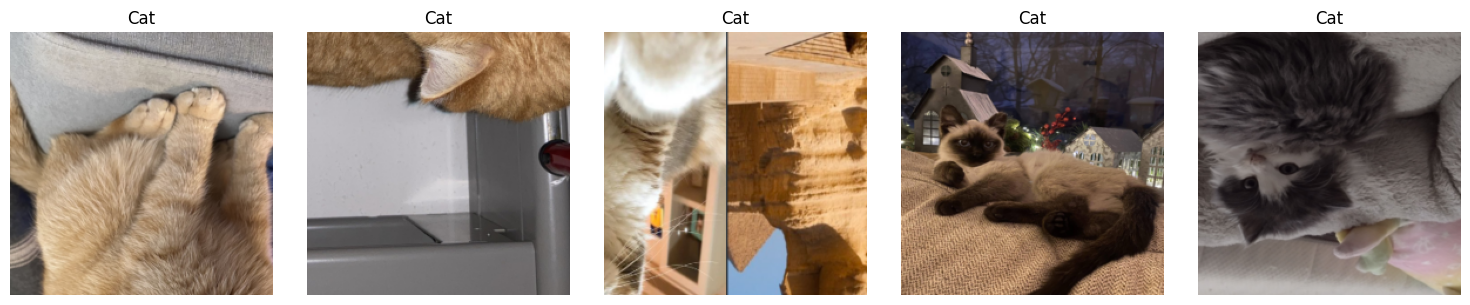

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the path to your root directory
data_root = "data"

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomResizedCrop((224, 224)),
    transforms.Resize((224, 224)),  # Resize the images to a consistent size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Define the paths to the subdirectories
train_dir = data_root + "/training"
val_dir = data_root + "/validation"
test_dir = data_root + "/test"

# Load the images from the directories using ImageFolder with shuffle=True
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Modify the labels in the datasets to be binary (0 or 1)
train_dataset.targets = [0 if label == 0 else 1 for label in train_dataset.targets]
val_dataset.targets = [0 if label == 0 else 1 for label in val_dataset.targets]
test_dataset.targets = [0 if label == 0 else 1 for label in test_dataset.targets]

# Create data loaders for each dataset
batch_size = 8
num_workers = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)

# Select a few images to display from the shuffled training dataset
num_images = 5
selected_images = [train_dataset[i] for i in range(num_images)]

# Display the selected images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i, (image, label) in enumerate(selected_images):
    image = image.cpu()  # Ensure that the image is on the CPU before displaying
    axes[i].imshow(image.permute(1, 2, 0))  # permute to change tensor shape (C, H, W) to (H, W, C)
    if label == 1:
        axes[i].set_title("Not Cat")
    else:
        axes[i].set_title("Cat")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


Resultat vi har nu, er 3 forskellige datasets der er blevet indlæst. Derudover, har vi også fået fremvist nogle af de katte billeder der befinder sig i datasættet.

Jeg vil allerede nu sige at der har været en del problemer i det her step. Det her step er nemlig både indlæsning af data, men også transformation. De virker simple nok, men når man ender med at have en langsom model der er bottlenecked grundet indlæsning af data, og en model der også overfitter, så kommer man ret meget tilbage til det her skridt og forsøger at lave ændringer.

Men der vil være mere om de informationer senere. Det vigtigste nu, er at vi har vores 3 dataloaders og vi kan gøre brug af dem.

# Modellen

Den første del af modellen består af tre sekvensielle lag, der kombinerer ```konvolution```, ```batch normalization```, ```ReLU-aktivering``` og ```max pooling```. Disse lag er ansvarlige for at udtrække forskellige features fra billederne på forskellige abstraktionsniveauer.

Efter konvolutionslagene følger ```fully connected layers``` (også kaldet dense layers). Disse lag tager de flade features fra konvolutionsdelen og mapper dem til de ønskede outputklasser. Vores model har to fuldt forbundne lag med ReLU-aktivering og dropout-lag for at undgå overfitting. Endelig har vi et outputlag med to neuroner, der repræsenterer vores to kategorier: "katte" og "ikke katte".

Vores forward-metode i modellen beskriver, hvordan data strømmer gennem de forskellige lag. Inputbilledet gennemgår konvolutions- og pooling-operationer, derefter flades det ud og føres gennem de fuldt forbundne lag, og til sidst producerer outputlaget en vektor af scores for hver kategori.

Modellen der bliver vist her, er selvfølgeligt ikke den første model i gjorde brug af. Til at starte med havde vi en langt mere simpel og basal model, for at teste om tingene lige virkede. I takt med at vi så fik det til at virke, og vi endte med at opleve dårlig træningspræstation, så ændrede vi rundt i modellen, forsøgte at lave flere lag, eller gøre brug af andre metoder for at tvinge modellen til ikke at huske billeder, men mønstre. Dog dette er også noget der kommer mere om senere.

In [17]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 200)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(200, 100)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.45)

        self.fc3 = nn.Linear(100, 1)

        # Lavede en ændring i støørelsen på FC layers. Før var de meget store, like 512 -> 512 -> etc... prøver at eksperimentere med mindre størrelse.
        # Måske prøve at ændre i dropout, se om de også fikser stuff.

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout1(self.relu4(self.fc1(x)))
        x = self.dropout2(self.relu5(self.fc2(x)))
        x = self.fc3(x)
        return x


In [18]:
class EnhancedCNNModel(nn.Module):
    def __init__(self):
        super(EnhancedCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Third convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Fourth convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Fifth convolutional layer
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_layers(x)
        return x


Efter at have valgt / bygget vores model, så var der også et par ekstra der der lige skulle ordnes før at vi kunne gå igang med træningen.

Der er nemlig brug for en ```loss-function``` også kaldet en criterion. Udover det, skal vi også bruge en optimizer.

Eftersom at vi arbejder med at binary classification problem, så vil vi gøre brug af en loss function der er designet til dette. Hvilket er hvorfor vi valgte ```BCEWithLogitsLoss``` (Binary Cross Entropy).

In [19]:
# Create an instance of the CNN model
model = EnhancedCNNModel()

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # BinaryCrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Træning af modellen

Det næste skridt vil være at træne selve modellen.

For at undgå en stor lang kodeblok, har vi dog valgt at splitte træning og validation op i hver deres function. For at håndtere træningen, bliver der laver et loop der kalder på disse i hvert epoch. Dette trænings loop har også ```early stopping``` for at undgå for meget træning.

In [20]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

def train_one_epoch(model, loader, device, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loader_progress = tqdm(loader, desc="Training", ncols=0)

    for images, labels in loader_progress:
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted_labels = torch.round(torch.sigmoid(outputs))  # Apply threshold of 0.5 for binary classification
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)

        loader_progress.set_postfix(loss=running_loss/len(loader), accuracy=(correct/total)*100)

    return running_loss / len(loader), (correct/total)*100


def validate_one_epoch(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    loader_progress = tqdm(loader, desc="Validation", ncols=0)

    with torch.no_grad():
        for images, labels in loader_progress:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted_labels = torch.round(torch.sigmoid(outputs))  # Apply threshold of 0.5 for binary classification
            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)

            loader_progress.set_postfix(loss=running_loss / len(loader), accuracy=(correct / total) * 100)

    return running_loss / len(loader), (correct / total) * 100



def train_model(model, train_loader, val_loader, device, criterion, optimizer, num_epochs, patience=5):
    best_val_accuracy = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    epochs_trained = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, device, criterion, optimizer)
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, device, criterion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        epochs_trained += 1

        print(f"\nEpoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.2f}% "
              f"Validation Loss: {val_loss:.4f} Validation Accuracy: {val_accuracy:.2f}%\n")

        # check for improvement
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0  # reset counter

            # Save the model
            torch.save(model.state_dict(), 'best_model_enhanced.pth')
            print("New best model saved.")

        else:
            patience_counter += 1  # increment counter

        if patience_counter >= patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break

    return history, epochs_trained

In [21]:
# Training loop
num_epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assuming optimizer and criterion are defined
training_history, epochs_trained = train_model(model, train_loader, val_loader, device, criterion, optimizer, num_epochs, patience=25)

Training: 100% 630/630 [01:11<00:00,  8.77it/s, accuracy=65.3, loss=0.637]  
Validation: 100% 70/70 [00:11<00:00,  5.96it/s, accuracy=68, loss=0.59]    



Epoch [1/500] Train Loss: 0.6372 Train Accuracy: 65.29% Validation Loss: 0.5898 Validation Accuracy: 68.04%

New best model saved.


Training: 100% 630/630 [01:04<00:00,  9.78it/s, accuracy=68.3, loss=0.612]  
Validation: 100% 70/70 [00:11<00:00,  6.09it/s, accuracy=63, loss=0.64]    



Epoch [2/500] Train Loss: 0.6117 Train Accuracy: 68.35% Validation Loss: 0.6402 Validation Accuracy: 63.04%



Training: 100% 630/630 [01:04<00:00,  9.80it/s, accuracy=69.4, loss=0.608]   
Validation: 100% 70/70 [00:11<00:00,  6.00it/s, accuracy=64.5, loss=0.721] 



Epoch [3/500] Train Loss: 0.6083 Train Accuracy: 69.38% Validation Loss: 0.7207 Validation Accuracy: 64.46%



Training: 100% 630/630 [01:03<00:00,  9.92it/s, accuracy=69.2, loss=0.597]   
Validation: 100% 70/70 [00:11<00:00,  5.97it/s, accuracy=70.5, loss=0.587]



Epoch [4/500] Train Loss: 0.5971 Train Accuracy: 69.18% Validation Loss: 0.5869 Validation Accuracy: 70.54%

New best model saved.


Training: 100% 630/630 [01:03<00:00,  9.86it/s, accuracy=70.2, loss=0.592]   
Validation: 100% 70/70 [00:11<00:00,  6.03it/s, accuracy=73.2, loss=0.575] 



Epoch [5/500] Train Loss: 0.5918 Train Accuracy: 70.17% Validation Loss: 0.5750 Validation Accuracy: 73.21%

New best model saved.


Training: 100% 630/630 [01:03<00:00,  9.84it/s, accuracy=72, loss=0.582]     
Validation: 100% 70/70 [00:11<00:00,  6.00it/s, accuracy=73, loss=0.552]   



Epoch [6/500] Train Loss: 0.5816 Train Accuracy: 71.98% Validation Loss: 0.5518 Validation Accuracy: 73.04%



Training: 100% 630/630 [01:04<00:00,  9.80it/s, accuracy=71, loss=0.584]    
Validation: 100% 70/70 [00:11<00:00,  5.85it/s, accuracy=72.5, loss=0.565] 



Epoch [7/500] Train Loss: 0.5840 Train Accuracy: 71.05% Validation Loss: 0.5647 Validation Accuracy: 72.50%



Training: 100% 630/630 [01:03<00:00,  9.86it/s, accuracy=71.9, loss=0.569]  
Validation: 100% 70/70 [00:11<00:00,  5.98it/s, accuracy=70.2, loss=0.589] 



Epoch [8/500] Train Loss: 0.5688 Train Accuracy: 71.86% Validation Loss: 0.5888 Validation Accuracy: 70.18%



Training: 100% 630/630 [01:03<00:00,  9.86it/s, accuracy=71.7, loss=0.569]  
Validation: 100% 70/70 [00:11<00:00,  6.01it/s, accuracy=72.7, loss=0.6]   



Epoch [9/500] Train Loss: 0.5692 Train Accuracy: 71.66% Validation Loss: 0.5995 Validation Accuracy: 72.68%



Training: 100% 630/630 [01:03<00:00,  9.92it/s, accuracy=72.2, loss=0.566]  
Validation: 100% 70/70 [00:11<00:00,  5.91it/s, accuracy=70.7, loss=0.567] 



Epoch [10/500] Train Loss: 0.5663 Train Accuracy: 72.18% Validation Loss: 0.5671 Validation Accuracy: 70.71%



Training: 100% 630/630 [01:04<00:00,  9.78it/s, accuracy=73, loss=0.556]     
Validation: 100% 70/70 [00:11<00:00,  6.04it/s, accuracy=72.9, loss=0.54]  



Epoch [11/500] Train Loss: 0.5564 Train Accuracy: 73.01% Validation Loss: 0.5402 Validation Accuracy: 72.86%



Training: 100% 630/630 [01:03<00:00,  9.93it/s, accuracy=72.6, loss=0.56]   
Validation: 100% 70/70 [00:11<00:00,  6.15it/s, accuracy=68.4, loss=0.605] 



Epoch [12/500] Train Loss: 0.5602 Train Accuracy: 72.62% Validation Loss: 0.6049 Validation Accuracy: 68.39%



Training: 100% 630/630 [01:04<00:00,  9.81it/s, accuracy=72.7, loss=0.557]   
Validation: 100% 70/70 [00:11<00:00,  5.97it/s, accuracy=70.5, loss=0.597] 



Epoch [13/500] Train Loss: 0.5568 Train Accuracy: 72.72% Validation Loss: 0.5974 Validation Accuracy: 70.54%



Training: 100% 630/630 [01:02<00:00, 10.02it/s, accuracy=73.1, loss=0.555]  
Validation: 100% 70/70 [00:11<00:00,  5.95it/s, accuracy=74.5, loss=0.556] 



Epoch [14/500] Train Loss: 0.5550 Train Accuracy: 73.09% Validation Loss: 0.5556 Validation Accuracy: 74.46%

New best model saved.


Training: 100% 630/630 [01:03<00:00,  9.89it/s, accuracy=73, loss=0.551]    
Validation: 100% 70/70 [00:11<00:00,  5.97it/s, accuracy=70.4, loss=0.569] 



Epoch [15/500] Train Loss: 0.5506 Train Accuracy: 73.03% Validation Loss: 0.5689 Validation Accuracy: 70.36%



Training: 100% 630/630 [01:02<00:00, 10.03it/s, accuracy=73.8, loss=0.549]  
Validation: 100% 70/70 [00:11<00:00,  6.00it/s, accuracy=75.2, loss=0.539] 



Epoch [16/500] Train Loss: 0.5488 Train Accuracy: 73.79% Validation Loss: 0.5393 Validation Accuracy: 75.18%

New best model saved.


Training: 100% 630/630 [01:03<00:00,  9.95it/s, accuracy=73.9, loss=0.541]  
Validation: 100% 70/70 [00:11<00:00,  5.94it/s, accuracy=76.2, loss=0.52]  



Epoch [17/500] Train Loss: 0.5406 Train Accuracy: 73.93% Validation Loss: 0.5199 Validation Accuracy: 76.25%

New best model saved.


Training: 100% 630/630 [01:03<00:00,  9.93it/s, accuracy=74.2, loss=0.543]  
Validation: 100% 70/70 [00:11<00:00,  5.93it/s, accuracy=75.9, loss=0.506] 



Epoch [18/500] Train Loss: 0.5429 Train Accuracy: 74.23% Validation Loss: 0.5061 Validation Accuracy: 75.89%



Training: 100% 630/630 [01:03<00:00,  9.92it/s, accuracy=74.4, loss=0.541]  
Validation: 100% 70/70 [00:11<00:00,  6.07it/s, accuracy=62.9, loss=1.14]  



Epoch [19/500] Train Loss: 0.5407 Train Accuracy: 74.36% Validation Loss: 1.1354 Validation Accuracy: 62.86%



Training: 100% 630/630 [01:04<00:00,  9.83it/s, accuracy=74.5, loss=0.543]  
Validation: 100% 70/70 [00:11<00:00,  5.92it/s, accuracy=73.4, loss=0.535] 



Epoch [20/500] Train Loss: 0.5427 Train Accuracy: 74.52% Validation Loss: 0.5351 Validation Accuracy: 73.39%



Training: 100% 630/630 [01:04<00:00,  9.84it/s, accuracy=75.9, loss=0.525]  
Validation: 100% 70/70 [00:11<00:00,  5.95it/s, accuracy=74.8, loss=0.528] 



Epoch [21/500] Train Loss: 0.5248 Train Accuracy: 75.87% Validation Loss: 0.5280 Validation Accuracy: 74.82%



Training: 100% 630/630 [01:03<00:00,  9.94it/s, accuracy=75.4, loss=0.528]   
Validation: 100% 70/70 [00:11<00:00,  5.87it/s, accuracy=77.7, loss=0.517] 



Epoch [22/500] Train Loss: 0.5280 Train Accuracy: 75.42% Validation Loss: 0.5168 Validation Accuracy: 77.68%

New best model saved.


Training: 100% 630/630 [01:03<00:00,  9.88it/s, accuracy=75.3, loss=0.531]  
Validation: 100% 70/70 [00:11<00:00,  5.90it/s, accuracy=76.8, loss=0.515] 



Epoch [23/500] Train Loss: 0.5308 Train Accuracy: 75.26% Validation Loss: 0.5147 Validation Accuracy: 76.79%



Training: 100% 630/630 [01:04<00:00,  9.83it/s, accuracy=75.3, loss=0.521]  
Validation: 100% 70/70 [00:11<00:00,  5.87it/s, accuracy=68, loss=0.774]   



Epoch [24/500] Train Loss: 0.5206 Train Accuracy: 75.26% Validation Loss: 0.7744 Validation Accuracy: 68.04%



Training: 100% 630/630 [01:03<00:00,  9.88it/s, accuracy=75.6, loss=0.525]  
Validation: 100% 70/70 [00:11<00:00,  6.01it/s, accuracy=76.1, loss=0.527] 



Epoch [25/500] Train Loss: 0.5253 Train Accuracy: 75.64% Validation Loss: 0.5268 Validation Accuracy: 76.07%



Training: 100% 630/630 [01:03<00:00,  9.85it/s, accuracy=75.8, loss=0.511]   
Validation: 100% 70/70 [00:11<00:00,  5.91it/s, accuracy=76.6, loss=0.507] 



Epoch [26/500] Train Loss: 0.5113 Train Accuracy: 75.81% Validation Loss: 0.5070 Validation Accuracy: 76.61%



Training: 100% 630/630 [01:03<00:00,  9.92it/s, accuracy=76.4, loss=0.508]   
Validation: 100% 70/70 [00:11<00:00,  5.95it/s, accuracy=75.2, loss=0.518] 



Epoch [27/500] Train Loss: 0.5079 Train Accuracy: 76.35% Validation Loss: 0.5176 Validation Accuracy: 75.18%



Training: 100% 630/630 [01:03<00:00,  9.85it/s, accuracy=75, loss=0.528]    
Validation: 100% 70/70 [00:11<00:00,  6.08it/s, accuracy=73.8, loss=0.547] 



Epoch [28/500] Train Loss: 0.5281 Train Accuracy: 75.04% Validation Loss: 0.5472 Validation Accuracy: 73.75%



Training: 100% 630/630 [01:04<00:00,  9.83it/s, accuracy=76.4, loss=0.51]   
Validation: 100% 70/70 [00:11<00:00,  5.96it/s, accuracy=75.4, loss=0.524] 



Epoch [29/500] Train Loss: 0.5105 Train Accuracy: 76.35% Validation Loss: 0.5237 Validation Accuracy: 75.36%



Training: 100% 630/630 [01:03<00:00,  9.97it/s, accuracy=75.8, loss=0.516]  
Validation: 100% 70/70 [00:11<00:00,  5.88it/s, accuracy=69.5, loss=0.667] 



Epoch [30/500] Train Loss: 0.5160 Train Accuracy: 75.81% Validation Loss: 0.6670 Validation Accuracy: 69.46%



Training: 100% 630/630 [01:03<00:00,  9.92it/s, accuracy=76.6, loss=0.503]  
Validation: 100% 70/70 [00:11<00:00,  5.98it/s, accuracy=74.8, loss=0.521] 



Epoch [31/500] Train Loss: 0.5025 Train Accuracy: 76.63% Validation Loss: 0.5206 Validation Accuracy: 74.82%



Training: 100% 630/630 [01:03<00:00,  9.96it/s, accuracy=76.4, loss=0.508]   
Validation: 100% 70/70 [00:11<00:00,  6.04it/s, accuracy=75.5, loss=0.514] 



Epoch [32/500] Train Loss: 0.5075 Train Accuracy: 76.41% Validation Loss: 0.5136 Validation Accuracy: 75.54%



Training: 100% 630/630 [01:03<00:00,  9.90it/s, accuracy=76.6, loss=0.501]  
Validation: 100% 70/70 [00:12<00:00,  5.55it/s, accuracy=76.4, loss=0.494] 



Epoch [33/500] Train Loss: 0.5011 Train Accuracy: 76.63% Validation Loss: 0.4937 Validation Accuracy: 76.43%



Training: 100% 630/630 [01:03<00:00,  9.89it/s, accuracy=77.7, loss=0.493]  
Validation: 100% 70/70 [00:11<00:00,  5.99it/s, accuracy=72, loss=0.576]   



Epoch [34/500] Train Loss: 0.4932 Train Accuracy: 77.66% Validation Loss: 0.5756 Validation Accuracy: 71.96%



Training: 100% 630/630 [01:03<00:00,  9.86it/s, accuracy=77.1, loss=0.499]   
Validation: 100% 70/70 [00:11<00:00,  5.96it/s, accuracy=77.7, loss=0.488] 



Epoch [35/500] Train Loss: 0.4992 Train Accuracy: 77.14% Validation Loss: 0.4876 Validation Accuracy: 77.68%



Training: 100% 630/630 [01:04<00:00,  9.80it/s, accuracy=76.5, loss=0.486]  
Validation: 100% 70/70 [00:11<00:00,  5.94it/s, accuracy=79.1, loss=0.489] 



Epoch [36/500] Train Loss: 0.4864 Train Accuracy: 76.55% Validation Loss: 0.4891 Validation Accuracy: 79.11%

New best model saved.


Training: 100% 630/630 [01:04<00:00,  9.83it/s, accuracy=76.8, loss=0.496]  
Validation: 100% 70/70 [00:12<00:00,  5.62it/s, accuracy=75, loss=0.622]   



Epoch [37/500] Train Loss: 0.4956 Train Accuracy: 76.85% Validation Loss: 0.6224 Validation Accuracy: 75.00%



Training: 100% 630/630 [01:03<00:00,  9.86it/s, accuracy=77.5, loss=0.495]   
Validation: 100% 70/70 [00:12<00:00,  5.79it/s, accuracy=77.3, loss=0.515] 



Epoch [38/500] Train Loss: 0.4949 Train Accuracy: 77.46% Validation Loss: 0.5153 Validation Accuracy: 77.32%



Training: 100% 630/630 [01:04<00:00,  9.81it/s, accuracy=76.6, loss=0.5]    
Validation: 100% 70/70 [00:12<00:00,  5.77it/s, accuracy=74.8, loss=0.518] 



Epoch [39/500] Train Loss: 0.4999 Train Accuracy: 76.63% Validation Loss: 0.5183 Validation Accuracy: 74.82%



Training: 100% 630/630 [01:05<00:00,  9.62it/s, accuracy=77.4, loss=0.489]  
Validation: 100% 70/70 [00:11<00:00,  5.98it/s, accuracy=75.4, loss=0.513] 



Epoch [40/500] Train Loss: 0.4888 Train Accuracy: 77.42% Validation Loss: 0.5132 Validation Accuracy: 75.36%



Training: 100% 630/630 [01:04<00:00,  9.81it/s, accuracy=78.4, loss=0.481]   
Validation: 100% 70/70 [00:12<00:00,  5.81it/s, accuracy=75.7, loss=0.524] 



Epoch [41/500] Train Loss: 0.4812 Train Accuracy: 78.36% Validation Loss: 0.5235 Validation Accuracy: 75.71%



Training: 100% 630/630 [01:03<00:00,  9.97it/s, accuracy=77.6, loss=0.487]  
Validation: 100% 70/70 [00:11<00:00,  5.92it/s, accuracy=76.6, loss=0.502] 



Epoch [42/500] Train Loss: 0.4867 Train Accuracy: 77.60% Validation Loss: 0.5017 Validation Accuracy: 76.61%



Training: 100% 630/630 [01:03<00:00,  9.93it/s, accuracy=78, loss=0.483]     
Validation: 100% 70/70 [00:11<00:00,  5.99it/s, accuracy=77.5, loss=0.508] 



Epoch [43/500] Train Loss: 0.4827 Train Accuracy: 78.04% Validation Loss: 0.5079 Validation Accuracy: 77.50%



Training: 100% 630/630 [01:03<00:00,  9.87it/s, accuracy=78, loss=0.479]    
Validation: 100% 70/70 [00:12<00:00,  5.80it/s, accuracy=77.9, loss=0.502] 



Epoch [44/500] Train Loss: 0.4792 Train Accuracy: 78.02% Validation Loss: 0.5021 Validation Accuracy: 77.86%



Training: 100% 630/630 [01:03<00:00,  9.93it/s, accuracy=78.3, loss=0.481]  
Validation: 100% 70/70 [00:11<00:00,  5.94it/s, accuracy=77.7, loss=0.489] 



Epoch [45/500] Train Loss: 0.4814 Train Accuracy: 78.30% Validation Loss: 0.4890 Validation Accuracy: 77.68%



Training: 100% 630/630 [01:03<00:00,  9.86it/s, accuracy=78.3, loss=0.475]  
Validation: 100% 70/70 [00:11<00:00,  5.86it/s, accuracy=79.1, loss=0.483] 



Epoch [46/500] Train Loss: 0.4746 Train Accuracy: 78.30% Validation Loss: 0.4831 Validation Accuracy: 79.11%



Training: 100% 630/630 [01:03<00:00,  9.86it/s, accuracy=78.1, loss=0.478]   
Validation: 100% 70/70 [00:11<00:00,  6.05it/s, accuracy=73.6, loss=0.544] 



Epoch [47/500] Train Loss: 0.4784 Train Accuracy: 78.10% Validation Loss: 0.5444 Validation Accuracy: 73.57%



Training: 100% 630/630 [01:03<00:00,  9.90it/s, accuracy=78.5, loss=0.469]  
Validation: 100% 70/70 [00:11<00:00,  5.97it/s, accuracy=73.8, loss=0.55] 



Epoch [48/500] Train Loss: 0.4692 Train Accuracy: 78.53% Validation Loss: 0.5500 Validation Accuracy: 73.75%



Training: 100% 630/630 [01:03<00:00,  9.95it/s, accuracy=78.1, loss=0.479]  
Validation: 100% 70/70 [00:11<00:00,  6.11it/s, accuracy=73.8, loss=0.508] 



Epoch [49/500] Train Loss: 0.4790 Train Accuracy: 78.12% Validation Loss: 0.5080 Validation Accuracy: 73.75%



Training: 100% 630/630 [01:03<00:00,  9.95it/s, accuracy=78.4, loss=0.476]  
Validation: 100% 70/70 [00:11<00:00,  5.99it/s, accuracy=75.9, loss=0.508] 



Epoch [50/500] Train Loss: 0.4760 Train Accuracy: 78.40% Validation Loss: 0.5076 Validation Accuracy: 75.89%



Training: 100% 630/630 [01:03<00:00,  9.91it/s, accuracy=79.2, loss=0.466]   
Validation: 100% 70/70 [00:11<00:00,  5.96it/s, accuracy=76.1, loss=0.487] 



Epoch [51/500] Train Loss: 0.4665 Train Accuracy: 79.21% Validation Loss: 0.4870 Validation Accuracy: 76.07%



Training: 100% 630/630 [01:04<00:00,  9.77it/s, accuracy=78.6, loss=0.464]   
Validation: 100% 70/70 [00:11<00:00,  5.86it/s, accuracy=77.3, loss=0.522] 



Epoch [52/500] Train Loss: 0.4641 Train Accuracy: 78.63% Validation Loss: 0.5223 Validation Accuracy: 77.32%



Training: 100% 630/630 [01:03<00:00,  9.86it/s, accuracy=77.9, loss=0.473]  
Validation: 100% 70/70 [00:11<00:00,  5.92it/s, accuracy=74.8, loss=0.568] 



Epoch [53/500] Train Loss: 0.4735 Train Accuracy: 77.90% Validation Loss: 0.5683 Validation Accuracy: 74.82%



Training: 100% 630/630 [01:04<00:00,  9.75it/s, accuracy=79, loss=0.466]     
Validation: 100% 70/70 [00:11<00:00,  6.14it/s, accuracy=77.3, loss=0.503] 



Epoch [54/500] Train Loss: 0.4662 Train Accuracy: 79.01% Validation Loss: 0.5028 Validation Accuracy: 77.32%



Training: 100% 630/630 [01:03<00:00,  9.92it/s, accuracy=77.9, loss=0.472]  
Validation: 100% 70/70 [00:11<00:00,  6.01it/s, accuracy=75.5, loss=0.497] 



Epoch [55/500] Train Loss: 0.4715 Train Accuracy: 77.88% Validation Loss: 0.4971 Validation Accuracy: 75.54%



Training: 100% 630/630 [01:03<00:00,  9.92it/s, accuracy=78.7, loss=0.464]  
Validation: 100% 70/70 [00:11<00:00,  5.88it/s, accuracy=77.1, loss=0.484] 



Epoch [56/500] Train Loss: 0.4640 Train Accuracy: 78.73% Validation Loss: 0.4841 Validation Accuracy: 77.14%



Training: 100% 630/630 [01:03<00:00,  9.91it/s, accuracy=78.1, loss=0.461]   
Validation: 100% 70/70 [00:11<00:00,  6.06it/s, accuracy=76.8, loss=0.507] 



Epoch [57/500] Train Loss: 0.4607 Train Accuracy: 78.10% Validation Loss: 0.5073 Validation Accuracy: 76.79%



Training: 100% 630/630 [01:03<00:00,  9.89it/s, accuracy=77.8, loss=0.471]  
Validation: 100% 70/70 [00:11<00:00,  5.90it/s, accuracy=76.4, loss=0.519] 



Epoch [58/500] Train Loss: 0.4709 Train Accuracy: 77.84% Validation Loss: 0.5190 Validation Accuracy: 76.43%



Training: 100% 630/630 [01:04<00:00,  9.84it/s, accuracy=79.1, loss=0.462]  
Validation: 100% 70/70 [00:11<00:00,  5.95it/s, accuracy=73.8, loss=0.533] 



Epoch [59/500] Train Loss: 0.4622 Train Accuracy: 79.11% Validation Loss: 0.5332 Validation Accuracy: 73.75%



Training: 100% 630/630 [01:03<00:00,  9.97it/s, accuracy=78.7, loss=0.465]  
Validation: 100% 70/70 [00:11<00:00,  5.92it/s, accuracy=74.8, loss=0.532] 



Epoch [60/500] Train Loss: 0.4647 Train Accuracy: 78.71% Validation Loss: 0.5315 Validation Accuracy: 74.82%



Training: 100% 630/630 [01:04<00:00,  9.81it/s, accuracy=79, loss=0.459]    
Validation: 100% 70/70 [00:12<00:00,  5.81it/s, accuracy=80, loss=0.483]   



Epoch [61/500] Train Loss: 0.4588 Train Accuracy: 78.99% Validation Loss: 0.4827 Validation Accuracy: 80.00%

New best model saved.


Training: 100% 630/630 [01:03<00:00,  9.91it/s, accuracy=79.4, loss=0.449]  
Validation: 100% 70/70 [00:11<00:00,  5.91it/s, accuracy=77.7, loss=0.493] 



Epoch [62/500] Train Loss: 0.4491 Train Accuracy: 79.41% Validation Loss: 0.4926 Validation Accuracy: 77.68%



Training: 100% 630/630 [01:04<00:00,  9.81it/s, accuracy=80.4, loss=0.444]  
Validation: 100% 70/70 [00:11<00:00,  6.05it/s, accuracy=76.8, loss=0.49]  



Epoch [63/500] Train Loss: 0.4438 Train Accuracy: 80.42% Validation Loss: 0.4902 Validation Accuracy: 76.79%



Training: 100% 630/630 [01:03<00:00,  9.91it/s, accuracy=80, loss=0.445]    
Validation: 100% 70/70 [00:11<00:00,  6.08it/s, accuracy=76.6, loss=0.499] 



Epoch [64/500] Train Loss: 0.4454 Train Accuracy: 80.02% Validation Loss: 0.4989 Validation Accuracy: 76.61%



Training: 100% 630/630 [01:03<00:00,  9.87it/s, accuracy=78.4, loss=0.463]   
Validation: 100% 70/70 [00:11<00:00,  5.90it/s, accuracy=76.1, loss=0.521] 



Epoch [65/500] Train Loss: 0.4629 Train Accuracy: 78.36% Validation Loss: 0.5210 Validation Accuracy: 76.07%



Training: 100% 630/630 [01:03<00:00,  9.88it/s, accuracy=79.9, loss=0.451]   
Validation: 100% 70/70 [00:11<00:00,  6.05it/s, accuracy=77.1, loss=0.513] 



Epoch [66/500] Train Loss: 0.4507 Train Accuracy: 79.92% Validation Loss: 0.5134 Validation Accuracy: 77.14%



Training: 100% 630/630 [01:03<00:00,  9.90it/s, accuracy=79.2, loss=0.454]  
Validation: 100% 70/70 [00:11<00:00,  6.01it/s, accuracy=78.2, loss=0.487] 



Epoch [67/500] Train Loss: 0.4535 Train Accuracy: 79.17% Validation Loss: 0.4870 Validation Accuracy: 78.21%



Training: 100% 630/630 [01:03<00:00,  9.88it/s, accuracy=79.9, loss=0.449]   
Validation: 100% 70/70 [00:11<00:00,  6.04it/s, accuracy=76.1, loss=0.504] 



Epoch [68/500] Train Loss: 0.4488 Train Accuracy: 79.92% Validation Loss: 0.5038 Validation Accuracy: 76.07%



Training: 100% 630/630 [01:04<00:00,  9.80it/s, accuracy=79.7, loss=0.452]  
Validation: 100% 70/70 [00:11<00:00,  5.90it/s, accuracy=78.4, loss=0.502] 



Epoch [69/500] Train Loss: 0.4524 Train Accuracy: 79.75% Validation Loss: 0.5025 Validation Accuracy: 78.39%



Training: 100% 630/630 [01:02<00:00, 10.01it/s, accuracy=80.4, loss=0.45]    
Validation: 100% 70/70 [00:11<00:00,  6.02it/s, accuracy=70.7, loss=0.561]



Epoch [70/500] Train Loss: 0.4503 Train Accuracy: 80.40% Validation Loss: 0.5606 Validation Accuracy: 70.71%



Training: 100% 630/630 [01:02<00:00, 10.05it/s, accuracy=79.7, loss=0.45]    
Validation: 100% 70/70 [00:11<00:00,  6.16it/s, accuracy=75.5, loss=0.494]



Epoch [71/500] Train Loss: 0.4498 Train Accuracy: 79.69% Validation Loss: 0.4938 Validation Accuracy: 75.54%



Training: 100% 630/630 [01:13<00:00,  8.60it/s, accuracy=79.8, loss=0.452]  
Validation: 100% 70/70 [00:12<00:00,  5.44it/s, accuracy=79.5, loss=0.469] 



Epoch [72/500] Train Loss: 0.4517 Train Accuracy: 79.77% Validation Loss: 0.4691 Validation Accuracy: 79.46%



Training: 100% 630/630 [01:04<00:00,  9.83it/s, accuracy=80.6, loss=0.436]  
Validation: 100% 70/70 [00:12<00:00,  5.68it/s, accuracy=78.2, loss=0.535] 



Epoch [73/500] Train Loss: 0.4357 Train Accuracy: 80.60% Validation Loss: 0.5347 Validation Accuracy: 78.21%



Training: 100% 630/630 [01:05<00:00,  9.56it/s, accuracy=78.9, loss=0.45]    
Validation: 100% 70/70 [00:12<00:00,  5.82it/s, accuracy=78.4, loss=0.51]  



Epoch [74/500] Train Loss: 0.4504 Train Accuracy: 78.93% Validation Loss: 0.5103 Validation Accuracy: 78.39%



Training: 100% 630/630 [01:06<00:00,  9.53it/s, accuracy=80.4, loss=0.434]  
Validation: 100% 70/70 [00:12<00:00,  5.42it/s, accuracy=77.9, loss=0.489] 



Epoch [75/500] Train Loss: 0.4340 Train Accuracy: 80.42% Validation Loss: 0.4895 Validation Accuracy: 77.86%



Training: 100% 630/630 [01:09<00:00,  9.06it/s, accuracy=80.3, loss=0.45]   
Validation: 100% 70/70 [00:12<00:00,  5.64it/s, accuracy=76.6, loss=0.498]



Epoch [76/500] Train Loss: 0.4501 Train Accuracy: 80.30% Validation Loss: 0.4975 Validation Accuracy: 76.61%



Training: 100% 630/630 [01:08<00:00,  9.21it/s, accuracy=80.9, loss=0.435]   
Validation: 100% 70/70 [00:13<00:00,  5.19it/s, accuracy=76.2, loss=0.507] 



Epoch [77/500] Train Loss: 0.4347 Train Accuracy: 80.88% Validation Loss: 0.5072 Validation Accuracy: 76.25%



Training: 100% 630/630 [01:12<00:00,  8.72it/s, accuracy=80.7, loss=0.434]   
Validation: 100% 70/70 [00:13<00:00,  5.26it/s, accuracy=78.4, loss=0.525] 



Epoch [78/500] Train Loss: 0.4335 Train Accuracy: 80.74% Validation Loss: 0.5250 Validation Accuracy: 78.39%



Training: 100% 630/630 [01:12<00:00,  8.75it/s, accuracy=81.2, loss=0.437]   
Validation: 100% 70/70 [00:14<00:00,  4.98it/s, accuracy=76.1, loss=0.501] 



Epoch [79/500] Train Loss: 0.4371 Train Accuracy: 81.16% Validation Loss: 0.5011 Validation Accuracy: 76.07%



Training: 100% 630/630 [01:11<00:00,  8.86it/s, accuracy=80.5, loss=0.438]  
Validation: 100% 70/70 [00:12<00:00,  5.41it/s, accuracy=76.4, loss=0.518]



Epoch [80/500] Train Loss: 0.4377 Train Accuracy: 80.48% Validation Loss: 0.5178 Validation Accuracy: 76.43%



Training: 100% 630/630 [01:08<00:00,  9.14it/s, accuracy=80.5, loss=0.436]   
Validation: 100% 70/70 [00:12<00:00,  5.80it/s, accuracy=77, loss=0.537]   



Epoch [81/500] Train Loss: 0.4359 Train Accuracy: 80.46% Validation Loss: 0.5372 Validation Accuracy: 76.96%



Training: 100% 630/630 [01:10<00:00,  8.93it/s, accuracy=80.6, loss=0.439]  
Validation: 100% 70/70 [00:15<00:00,  4.52it/s, accuracy=77.9, loss=0.518] 



Epoch [82/500] Train Loss: 0.4391 Train Accuracy: 80.56% Validation Loss: 0.5176 Validation Accuracy: 77.86%



Training: 100% 630/630 [01:10<00:00,  8.98it/s, accuracy=80.7, loss=0.435]  
Validation: 100% 70/70 [00:13<00:00,  5.29it/s, accuracy=76.4, loss=0.502] 



Epoch [83/500] Train Loss: 0.4348 Train Accuracy: 80.68% Validation Loss: 0.5017 Validation Accuracy: 76.43%



Training: 100% 630/630 [01:10<00:00,  8.91it/s, accuracy=81.9, loss=0.429]   
Validation: 100% 70/70 [00:13<00:00,  5.22it/s, accuracy=77.7, loss=0.497] 



Epoch [84/500] Train Loss: 0.4286 Train Accuracy: 81.95% Validation Loss: 0.4968 Validation Accuracy: 77.68%



Training: 100% 630/630 [01:09<00:00,  9.12it/s, accuracy=80.5, loss=0.436]  
Validation: 100% 70/70 [00:13<00:00,  5.17it/s, accuracy=79.5, loss=0.477] 



Epoch [85/500] Train Loss: 0.4355 Train Accuracy: 80.48% Validation Loss: 0.4774 Validation Accuracy: 79.46%



Training: 100% 630/630 [01:09<00:00,  9.12it/s, accuracy=81.1, loss=0.43]    
Validation: 100% 70/70 [00:12<00:00,  5.45it/s, accuracy=79.8, loss=0.464]


Epoch [86/500] Train Loss: 0.4300 Train Accuracy: 81.10% Validation Loss: 0.4642 Validation Accuracy: 79.82%

Early stopping due to no improvement in validation accuracy.


Efter at have trænet vores model, bliver den hurtigt lige gemt lokalt, så man lettere i fremtiden kan indlæse den.

In [22]:
# Assuming you have a trained model called "model"
# Save the model's state dictionary
torch.save(model.state_dict(), 'model_state_dictionary.pth')

# Save the entire model
torch.save(model, 'model.pth')

## Visualisering af træning

For at gøre det lidt lettere at forstå hvor godt vores model klarer sig, valgte vi at visualisere historikken.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001E9645DB1A0>
Traceback (most recent call last):
  File "c:\Users\lazyT\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\lazyT\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


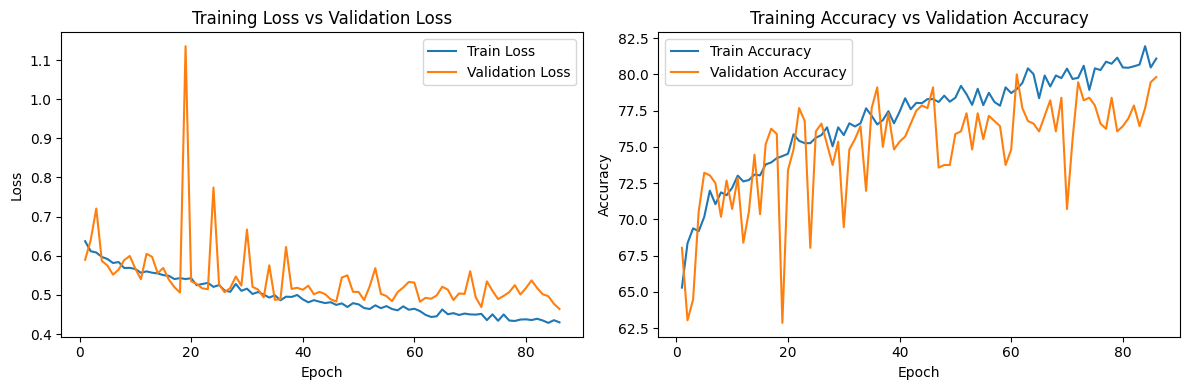

In [23]:
# Accessing the training history
train_loss_values = training_history['train_loss']
val_loss_values = training_history['val_loss']
train_accuracy_values = training_history['train_accuracy']
val_accuracy_values = training_history['val_accuracy']

# Example: Plotting the training loss and validation accuracy
#epochs = range(1, num_epochs + 1)
epochs = range(1, epochs_trained + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_values, label='Train Accuracy')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Test / Evaluering



In [24]:
def test_model(model, test_loader, device, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    loader_progress = tqdm(test_loader, desc="Testing", ncols=0)

    with torch.no_grad():
        for images, labels in loader_progress:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted_labels = torch.round(torch.sigmoid(outputs))  # Apply threshold of 0.5 for binary classification
            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)

            loader_progress.set_postfix(loss=running_loss / len(test_loader), accuracy=(correct / total) * 100)

    return running_loss / len(test_loader), (correct / total) * 100

In [25]:
# Load the best model
best_model = EnhancedCNNModel()  # replace Model() with your model class
best_model.load_state_dict(torch.load('best_model_enhanced.pth'))
best_model = best_model.to(device)

# Test the model
test_loss, test_accuracy = test_model(best_model, test_loader, device, criterion)

Testing: 100% 80/80 [00:36<00:00,  2.19it/s, accuracy=74.5, loss=0.527] 


In [26]:
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%\n")

Test Loss: 0.5270 Test Accuracy: 74.53%



# Opsamling

Okay, nu er vi så nået ned i slutningen af denne notebook.

Vi har gået igennem hele processen for at lave et neural network der kan bruges til binary classification af billeder.

## Vurdering af model

Den endegyldige model, havde en ```accuracy``` på 73,91% når man brugte test datasettet. Er det et godt resultat? Nej ikke rigtigt. Det er bedre end hvis man bare gættede, men det er stadigt ikke helt optimalt. 

Hvorfor var modellen så ikke helt så god? Well, der kan være mange årsager. Det kan være at netværket ikke er stærkt nok til at kunne finde mønstre. Det kan også være omvendt, og den så bare begynder at overfit. Det kan også være grundet den data vi havde at arbejde med. Som sagt, dataen blev taget direkte fra Reddit af, og på trods af at vi gik en del af det igennem og fjernede fx korrupte billeder, så er det slet ikke gået nok igennem til at vide at man har "god" data. Derudover, kan det så også være at vi bare slet ikke har data nok. Pt har vi cirka 3000 billeder af hver kategory som træning. Det kan som sagt være, at modellen ville have godt af at have endnu flere billeder.

## Tuning af model

Tuningen af modellen var ikke et punkt for sig selv i selve denne notebook. Grunden for det, er at det var noget der skete konstant.

Det var manuelt, hvilket betyder vi *ikke* gjorde brug af et library til automatisk at træne en masse ting igennem, og så give os det bedste resultat. Grunden til det, har været den meget langsomme træningstid, så der har simpelthen bare ikke været tid nok til at tage den brute-force gennemgang til det. Hvad vi i stedet gjorde, var at teste rundt på nogle af de forskellige elementer, og så lave den træne ~5 epochs, og se hvor stor forskel der var her mellem de tidligere. Dette er ikke en perfekt tilgang, og optimalt burde vi have lade det køre i langt længere tid. Dog som sagt, tiden var begrænsningen her.

Samlet set, kan vi sige at vi blandt andet tjekkede følgende ting, for at eksperimentere med vores model:

* Batchsize. Hvad var bedst? En stor batchsize, eller måske en lille?
* Forskellige netværker. Vi eksperimenterede meget med hvilken størrelse de burde have. Om hvor mange ```trainable parameters``` ville være for mange. Mange af vores tidligere modeller klarede sig langt værre end vores nuværende, grundet meget tidlig overfitting.
* Forskellige optimizers. Den vi endte med at gå med til sidst var ```Adam```, men udover det testede vi også SGD og AdamW. Der var ikke nogen virkelig forskel her for os.
* Forskellige learning rates. Vi endte med at gå med en learning rate på ```0.001```. Vi synes at fx ```0.01``` førte til for dårlige resultater, og ```0.0001``` betød at modellen aldrig lærte noget (den var hard-stuck på 50% validation).

## Problemer eller forbedringer

Det største problem der har været med det her netværk, har været indlæsningen af dataen. Rent faktisk, så har selve indlæsningen været rimelig nem. Dog så den process der bruges lige her nu, fører til meget stor CPU bottleneck.

Netværket blev trænet på en maskine der kører med: 
- CPU: i7 8700K @ 5Ghz
- RAM: 32GB 
- GPU: RTX 4070ti

Man skulle tro at det grafik kort ville kunne træne modellen rimeligt hurtigt, hvilket det nok også godt ville kunne gøre. Havde det ikke været fordi at CPU'en havde 100% forbrug under træningen af modellen, imens GPU'en sad på cirka 10% (med spikes til 25%). Efter at have læst rundt på nettet, virker det til at været I/O problem, med at GPU'en ikke kunne få data hurtigt nok. 

Vi endte med at bruge lidt for lang tid på at forsøge at få det løst - uden at vi dog fandt en løsning. Dog er dette et meget tydeligt og klart sted man ville kunne lave en forbedring, og få meget hurtigere træning.

Vi forsøgte at lege rundt med ```.hdf5``` filformater for at undgå det, og vi fik det til at virke... På bekostning af vores data. Der skete et eller andet med vores data, fordi vores models præcision gik fra (på det tidspunkt) 60% ned til 20%. Dog så var træningen også cirka 15 gange hurtigere, med en GPU der sad på 80% forbrug. Oh well, hvad vi forsøger at sige er at dette er et sted man godt ville kunne forbedre det på.